In [2]:
%%capture
%run 02_FeatEng.ipynb

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error  as skl_mse

In [4]:
import shap 
shap.initjs()

In [5]:
x_train = data_train[ar_features].copy()
y_train = data_train['cons_GNA95_pct_change1_t1'].copy()

In [6]:
x_test = data_test[ar_features].copy()
y_test = data_test['cons_GNA95_pct_change1_t1'].copy()

In [14]:
mape_train = (abs(data_train['cons_GNA95'].shift(-1) - data_train['cons_GNA95'])/data_test['cons_GNA95']).mean()
mape_test = (abs(data_test['cons_GNA95'].shift(-1) - data_test['cons_GNA95'])/data_test['cons_GNA95']).mean()

In [15]:
print(mape_train)
print(mape_test)

nan
0.06287432461686016


In [6]:
tscv = TimeSeriesSplit(n_splits=3)

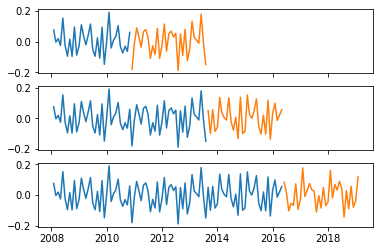

In [7]:
fig, axs = plt.subplots(3,1, sharex=True)

for i, (train_index, val_index) in enumerate(tscv.split(y_train)):
    axs[i].plot(y_train[train_index],label='train')
    axs[i].plot(y_train[val_index],label='valid')

In [70]:
rf  = RandomForestRegressor(criterion='mse', n_estimators=100, bootstrap=True, oob_score=True, ccp_alpha=0,
                            min_samples_leaf=3,
                            n_jobs=-1, random_state=123)

In [71]:
rf_hparams_grid = {'max_depth': [3, 6],
                    'max_features': [0.5, 0.75]}
rf_cv = GridSearchCV(rf, rf_hparams_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True, return_train_score=True)
rf_cv_res = rf_cv.fit(x_train, y_train)

In [72]:
rf_cv_res_df = pd.DataFrame(rf_cv_res.cv_results_)

In [73]:
rf_cv_mod = rf_cv_res.best_estimator_

In [74]:
rf_cv_mod

RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mse', max_depth=6,
                      max_features=0.75, max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=123, verbose=0,
                      warm_start=False)

In [105]:
p_gna95_train = pd.Series(index=data_train.index, data=rf_cv_mod.predict(x_train))
p_gna95_test = pd.Series(index=data_test.index, data=rf_cv_mod.predict(x_test))

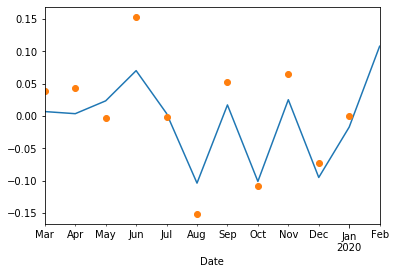

In [106]:
ax = p_gna95_test.plot()
y_test.plot(label='actual', style='o', ax=ax)
plt.show()

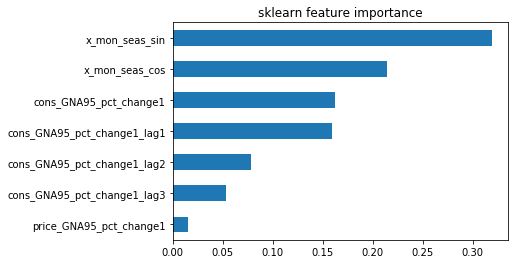

In [133]:
sklearn_fi = pd.Series(index=ar_features, data=rf_cv_mod.feature_importances_).sort_values(ascending=True)
sklearn_fi.plot.barh()
plt.title('sklearn feature importance')
plt.show()

In [148]:
explainer_model1 = shap.TreeExplainer(rf_cv_mod, feature_perturbation ='tree_path_dependent')
shap_values1 = explainer_model1.shap_values(x_train)

In [146]:
explainer_model2 = shap.TreeExplainer(rf_cv_mod, data =x_train)
shap_values2 = explainer_model2.shap_values(x_train)

In [152]:
print('Expected base value in shap algorithm: ', explainer_model1.expected_value)
print('Expected base value in shap algo, fit with data: ', explainer_model2.expected_value)
print('Target mean: ', y_train.mean())
print('Model prediction mean: ', p_gna95_train.mean())

Expected base value in shap algorithm:  [0.00362906]
Expected base value in shap algo, fit with data:  0.0025261212522233014
target mean:  0.002723530319090796
model prediction mean:  0.002526121252223296


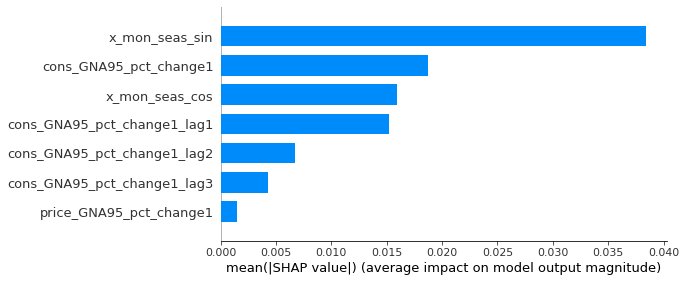

In [147]:
shap.summary_plot(shap_values2, x_train, plot_type="bar")

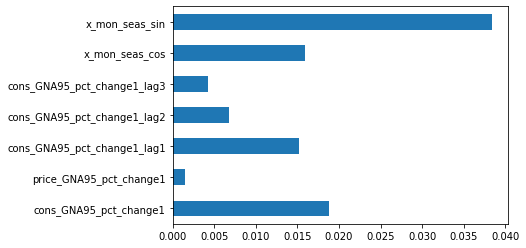

In [181]:
pd.Series(index=ar_features, data=abs(shap_values2).mean(axis=0)).plot.barh()

In [236]:
shap.initjs()
shap.force_plot(explainer_model2.expected_value, shap_values2[obs_j], x_train.iloc[[obs_j]], figsize =(16,4))

In [234]:
def shap_force_plot(base_value,  shap_values, features_data, obj_j):
    features_names = features_data.columns.tolist()
    shap_values_row = shap_values[obs_j]
    features_row = features_data.iloc[obs_j]
    shap_vals_j = pd.Series(index=features_names, data=shap_values_row).to_frame('raw shap values j')
    shap_vals_j['shap values j'] = shap_vals_j['raw shap values j'] + base_value
    shap_vals_j['contrib to base value'] = np.where(shap_vals_j['raw shap values j']>0, 'positive', 'negative')
    ax = sns.barplot(data=shap_vals_j, x='raw shap values j', y=ar_features, hue='contrib to base value')
    plt.title('Force plot: Shap contribution to prediction by feature')
    return ax

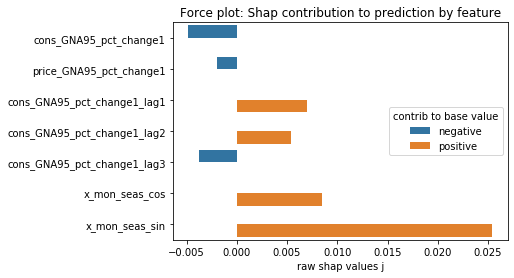

In [235]:
ax = shap_force_plot(base_value=explainer_model2.expected_value,  shap_values=shap_values2, features_data=x_train, obj_j=3)
plt.show()

In [239]:
x_train.iloc[3:4].T

Date,2008-05-01
cons_GNA95_pct_change1,0.019177
price_GNA95_pct_change1,0.052705
cons_GNA95_pct_change1_lag1,-0.003282
cons_GNA95_pct_change1_lag2,0.075551
cons_GNA95_pct_change1_lag3,-0.013249
x_mon_seas_cos,-0.866025
x_mon_seas_sin,0.500000
